# Context
**AI Platform Goal**
> **The AIP goal to make the Applied Scientist productive -> Increase Velocity**

***Problem:*** 
* Building a model workflow is a system/infra/SDK nightmare.  
* Especially when iterating from adhoc experimentation, to production, and back.

**Workflow SDK Goal**:

> **To increase AS velocity with a simple Pythonic SDK to express modeling intent, minimizing the effort to learn a suite of SDKs and engineering details.**

***Solution:***
* We found an open source project making headway in this direction, named Metaflow.
* AIP is based on Kubeflow and k8s stack. 
* We are bringing the best of Metaflow to you!

## What the Applied Scientist cares about

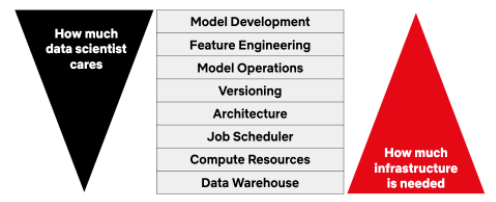

# Workflow Hello World
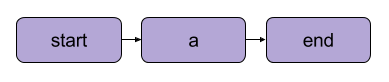

**Anatomy of a workflow:**
* 3 steps create a DAG
* `self.next` to construct it.
* print hello

In [ ]:
# %load metaflow/metaflow/tutorials/00-helloworld/helloworld.py
from metaflow import FlowSpec, step


class HelloFlow(FlowSpec):
    """
    A flow where Metaflow prints 'Hi'.
    """
    @step
    def start(self):
        """
        This is the 'start' step. All flows must have a step named 'start' that
        is the first step in the flow.

        """
        print("HelloFlow is starting.")
        self.next(self.hello)

    @step
    def hello(self):
        """
        A step for metaflow to introduce itself.

        """
        print("Metaflow says: Hi!")
        self.next(self.end)

    @step
    def end(self):
        """
        This is the 'end' step. All flows must have an 'end' step, which is the
        last step in the flow.

        """
        print("HelloFlow is all done.")


if __name__ == '__main__':
    HelloFlow()


In [1]:
!python metaflow/metaflow/tutorials/00-helloworld/helloworld.py run

Metaflow 2.2.5 executing HelloFlow for user:talebz@zillowgroup.com
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2021-02-17 18:01:04.776 Workflow starting (run-id 74):
2021-02-17 18:01:04.882 [74/start/516 (pid 134)] Task is starting.
2021-02-17 18:01:06.706 [74/start/516 (pid 134)] HelloFlow is starting.
2021-02-17 18:01:07.070 [74/start/516 (pid 134)] Task finished successfully.
2021-02-17 18:01:07.222 [74/hello/517 (pid 168)] Task is starting.
2021-02-17 18:01:09.130 [74/hello/517 (pid 168)] Metaflow says: Hi!
2021-02-17 18:01:09.491 [74/hello/517 (pid 168)] Task finished successfully.
2021-02-17 18:01:09.659 [74/end/518 (pid 204)] Task is starting.
2021-02-17 18:01:11.657 [74/end/518 (pid 204)] HelloFlow is all done.
2021-02-17 18:01:12.073 [74/end/518 (pid 204)] Task finished successfully.
2021-02-17 18:01:12.129 Done!


In [1]:
!python metaflow/metaflow/tutorials/00-helloworld/helloworld.py kfp run

Metaflow 2.2.5 executing HelloFlow for user:talebz@zillowgroup.com
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
Uploaded package to: s3://aip-example-stage/metaflow/HelloFlow/data/9f/9ff72d940ba5cfa66d15968d0e5709f87899017c
Deploying HelloFlow to Kubeflow Pipelines...

Run created successfully!

Metaflow run_id=kfp-9802c5e3-3e72-42da-98bf-7115dfbb70e5 

Run link: https://kubeflow.corp.stage-k8s.zg-aip.net/_/pipeline/#/runs/details/9802c5e3-3e72-42da-98bf-7115dfbb70e5



## Branching HelloWorld
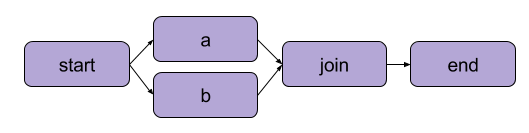

**We often times need a more complex flow for our models:**
* `self.x` can be set and joined
* join step to merge/join/reduce inputs
* Workflow handles parallelization for you

In [4]:
%%writefile demo_flows/branch_flow.py
from metaflow import FlowSpec, step

class BranchFlow(FlowSpec):

    @step
    def start(self):
        self.next(self.a, self.b)

    @step
    def a(self):
        self.x = 1
        self.next(self.join)

    @step
    def b(self):
        self.x = 2
        self.next(self.join)

    @step
    def join(self, inputs):
        print('a is %s' % inputs.a.x)
        print('b is %s' % inputs.b.x)
        print('total is %d' % sum(input.x for input in inputs))
        self.next(self.end)

    @step
    def end(self):
        pass

if __name__ == '__main__':
    BranchFlow()

Writing demo_flows/branch_flow.py


In [79]:
!python demo_flows/branch_flow.py run

Metaflow 2.0.5.post261+git0be9d90 executing BranchFlow for user:talebz@zillowgroup.com
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2020-12-11 23:31:31.468 Workflow starting (run-id 44):
2020-12-11 23:31:31.575 [44/start/335 (pid 14708)] Task is starting.
2020-12-11 23:31:34.035 [44/start/335 (pid 14708)] Task finished successfully.
2020-12-11 23:31:34.186 [44/a/336 (pid 14744)] Task is starting.
2020-12-11 23:31:34.282 [44/b/337 (pid 14747)] Task is starting.
2020-12-11 23:31:36.381 [44/a/336 (pid 14744)] Task finished successfully.
2020-12-11 23:31:36.734 [44/b/337 (pid 14747)] Task finished successfully.
2020-12-11 23:31:36.914 [44/join/338 (pid 14824)] Task is starting.
2020-12-11 23:31:39.742 [44/join/338 (pid 14824)] a is 1
2020-12-11 23:31:39.796 [44/join/338 (pid 14824)] b is 2
2020-12-11 23:31:39.796 [44/join/338 (pid 14824)] total is 3
2020-12-11 23:31:40.219 [44/join/338 (pid 14824)] Task finished successfully.
2020-12-11 23:31:40.

## Foreach HelloWorld
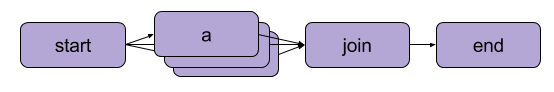

**Often need to parallize over a list:**
* `foreach=types`
* process in parallel
* join and reduce the results

In [1]:
!pwd

/opt/zillow/shared/taleb


In [76]:
%%writefile demo_flows/foreach_flow.py
from metaflow import FlowSpec, step

class ForeachFlow(FlowSpec):

    @step
    def start(self):
        self.types = ['homes',
                      'apartments',
                      'commercial']
        self.next(self.a, foreach='types')

    @step
    def a(self):
        self.types = f"{self.input} processed"
        self.next(self.join)

    @step
    def join(self, inputs):
        self.results = [input.types for input in inputs]
        self.next(self.end)

    @step
    def end(self):
        print('\n'.join(self.results))

if __name__ == '__main__':
    ForeachFlow()

Overwriting demo_flows/foreach_flow.py


In [77]:
!python demo_flows/foreach_flow.py run

Metaflow 2.0.5.post261+git0be9d90 executing ForeachFlow for user:talebz@zillowgroup.com
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2020-12-11 22:47:26.812 Workflow starting (run-id 42):
2020-12-11 22:47:26.909 [42/start/324 (pid 14280)] Task is starting.
2020-12-11 22:47:29.387 [42/start/324 (pid 14280)] Foreach yields 3 child steps.
2020-12-11 22:47:29.387 [42/start/324 (pid 14280)] Task finished successfully.
2020-12-11 22:47:29.565 [42/a/325 (pid 14318)] Task is starting.
2020-12-11 22:47:29.640 [42/a/326 (pid 14321)] Task is starting.
2020-12-11 22:47:29.717 [42/a/327 (pid 14324)] Task is starting.
2020-12-11 22:47:32.219 [42/a/326 (pid 14321)] Task finished successfully.
2020-12-11 22:47:32.566 [42/a/325 (pid 14318)] Task finished successfully.
2020-12-11 22:47:32.852 [42/a/327 (pid 14324)] Task finished successfully.
2020-12-11 22:47:33.097 [42/join/328 (pid 14462)] Task is starting.
2020-12-11 22:47:35.901 [42/join/328 (pid 14462)] T

## Nested Foreach Example

* We support more complex nested foreach flows.
* This example takes some time and have previously run.

https://kubeflow.corp.stage-k8s.zg-aip.net/_/pipeline/?ns=aip-example-dev#/runs/details/2b3bf9cc-7e7f-49da-a791-c13c549b5d5a

## Advanced Scenario: Recursion can be supported
* Flip a coin until it hits tails

https://kubeflow.corp.stage-k8s.zg-aip.net/_/pipeline/#/runs/details/07048957-ceaa-41cb-84b4-77e2477c273b

----
## Model Exploration Development Loop

### Let's run it locally, for fast iterative development
* This is a PyTorch model to be trained (on a GPU enabled Notebook)
* I can iterate and develop it locally

In [80]:
!python metaflow/metaflow/tutorials/10-pytorch/hello_pytorch.py run

Metaflow 2.0.5.post261+git0be9d90 executing HelloPyTorch for user:talebz@zillowgroup.com
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2020-12-11 23:34:28.498 Workflow starting (run-id 45):
2020-12-11 23:34:28.595 [45/start/341 (pid 14959)] Task is starting.
2020-12-11 23:34:31.559 [45/start/341 (pid 14959)] ranks: [0]
2020-12-11 23:34:31.996 [45/start/341 (pid 14959)] Foreach yields 1 child steps.
2020-12-11 23:34:31.997 [45/start/341 (pid 14959)] Task finished successfully.
2020-12-11 23:34:32.172 [45/train/342 (pid 15030)] Task is starting.
2020-12-11 23:34:37.934 [45/train/342 (pid 15030)] self.rank 0
2020-12-11 23:34:51.446 [45/train/342 (pid 15030)] Using CUDA
2020-12-11 23:34:51.446 [45/train/342 (pid 15030)] WORLD_SIZE = 1
2020-12-11 23:34:51.446 [45/train/342 (pid 15030)] RANK = 0
2020-12-11 23:34:51.447 [45/train/342 (pid 15030)] Dataset size = torch.Size([60000, 28, 28])
2020-12-11 23:34:51.447 [45/train/342 (pid 15030)] num_batches

---
## I can iterate on the code within my Notebook

- Open metaflow_pytorch directory (and train files)
- Describe the Flow steps
- @GPU and use in K8s cluster 
- code walkthrough

**Easy to:**
* Add Flow parameters
* Share state between Workflow steps!
---

## Let's use a Cluster of GPUs!

* Now I want to train on a much larger dataset.
* I can use a cluster for multiple GPU distrubted data parallel training. see `world_size 2`
* I could use a cluster for a single GPU to reduce GPU costs $$ (example: the notebook instance can be CPU only).

In [1]:
!python metaflow/metaflow/tutorials/10-pytorch/hello_pytorch.py kfp run --world_size 2 --base-image pytorch/pytorch:1.6.0-cuda10.1-cudnn7-runtime

Traceback (most recent call last):
  File "metaflow/metaflow/tutorials/10-pytorch/hello_pytorch.py", line 1, in <module>
    from metaflow import FlowSpec, Parameter, step, pytorch_distributed, resources
ImportError: cannot import name 'pytorch_distributed'


In [4]:
!python -m pip show metaflow

Name: metaflow
Version: 2.2.5
Summary: Metaflow: More Data Science, Less Engineering
Home-page: UNKNOWN
Author: Machine Learning Infrastructure Team at Netflix
Author-email: help@metaflow.org
License: Apache License 2.0
Location: /usr/local/lib/python3.6/site-packages
Requires: boto3, click, requests, kfp, pylint
Required-by: 


In [5]:
import metaflow

In [8]:
metaflow.__path__

['/usr/local/lib/python3.6/site-packages/metaflow']

m

----
* #### I can clone a run with new parameters.
----


## Post hoc Analysis

In [5]:
from metaflow import get_metadata, metadata, namespace, Step, Run, Flow
namespace('user:kfp-user')
# metadata('https://kubeflow.int.stage-k8s.zg-aip.net/metaflow-service/')
# metadata('https://kubeflow.int.stage-k8s.zg-aip.net/metaflow-service')
# metadata('https://kubeflow.int.dev.zg-aip.net/metaflow-service')

'user:kfp-user'

In [82]:
# lets see all the Flows that have run in this environment
from metaflow import Metaflow
Metaflow().flows

[Flow('NestedForeachTestFlow'),
 Flow('HelloPyTorch'),
 Flow('ExampleFlow'),
 Flow('NestedForeachWithBranching'),
 Flow('KfpGraphComponentFlow'),
 Flow('HelloPipeler'),
 Flow('KfpLoadComponent'),
 Flow('BranchFlow'),
 Flow('ForeachFlow')]

In [83]:
# Get the latest successful run
run = Flow('HelloPyTorch').latest_successful_run
run

Run('HelloPyTorch/kfp-f9d7e511-6ff7-44fc-a682-ec4bd25313cd')

#### Inspect
* Inspect the Flow state at the start step
* Metaflow has captured the Flow parameters as state. 
* Repeatable experiment

In [84]:
Step(f"{run.pathspec}/start").task.data

<MetaflowData: batch_size, epochs, input_data_path, lr, model_path, momentum, optimizer, test_accuracy_threshold, train_accuracy_threshold, ranks, name, seed, test_batch_size, world_size>

In [85]:
Step(f"{run.pathspec}/start").task.data.test_batch_size

1000

In [86]:
Step(f"{run.pathspec}/start").task.data.ranks

[0, 1]

In [87]:
# Evaluation results
Step(f"{run.pathspec}/end").task.data.evaluate_results

(0.7972333333333333, 0.8147)

In [88]:
# Trained NN
model_state_dict = Step(f"{run.pathspec}/end").task.data.model_state_dict
print(str(model_state_dict)[0:600])

OrderedDict([('conv1.weight', tensor([[[[ 0.1765,  0.2043, -0.0017,  0.2272, -0.0174],
          [ 0.0785, -0.0447,  0.1763,  0.2243, -0.1212],
          [ 0.2194,  0.0959,  0.2068,  0.0679,  0.1210],
          [ 0.0093,  0.2024,  0.0717, -0.0682,  0.0660],
          [-0.0673,  0.0071, -0.0574,  0.1472, -0.1521]]],


        [[[-0.0824, -0.0415, -0.1017,  0.0362, -0.1884],
          [ 0.2049, -0.1395,  0.1920,  0.0657, -0.0428],
          [ 0.1624,  0.0814,  0.2195,  0.0744, -0.0226],
          [ 0.0946, -0.0009,  0.1463,  0.2377,  0.1625],
          [-0.0586,  0.1580,  0.0830,  0.1433, -0.092


----
# Debugging

## Let's inspect the logs for the end step
#### note: This could be a production run!

In [89]:
!python metaflow/metaflow/tutorials/10-pytorch/hello_pytorch.py logs kfp-9a2bb02f-22a4-4fcb-9358-31af312905ee/end

Metaflow 2.0.5.post261+git0be9d90 executing HelloPyTorch for user:talebz@zillowgroup.com
Dumping logs of run_id=kfp-9a2bb02f-22a4-4fcb-9358-31af312905ee step=end task_id=kfp4
stdout
Setting up task environment.
Code package downloaded.
Task is starting.
evaluate_results: ['{}', '{"metrics": [{"name": "train_accuracy", "numberValue": 0.7973166666666667}, {"name": "test_accuracy", "numberValue": 0.8146}]}']
stderr


In [127]:
!python metaflow/metaflow/tutorials/10-pytorch/hello_pytorch.py logs kfp-9a2bb02f-22a4-4fcb-9358-31af312905ee/train

Metaflow 2.0.5.post261+git0be9d90 executing HelloPyTorch for user:talebz@zillowgroup.com
Dumping logs of run_id=kfp-9a2bb02f-22a4-4fcb-9358-31af312905ee step=train task_id=kfp2.0
stdout
Setting up task environment.
Code package downloaded.
Task is starting.
2020-12-11 03:46:25.392 PASSED_IN_SPLIT_INDEXES: 0
self.rank 0
Using CUDA
Using distributed PyTorch with nccl backend
WORLD_SIZE = 2
RANK = 0
Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw
Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw
Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!
Dataset size = torch.Size([60000, 28, 28])
num_batches = 120
batch size = 500
Train dataset size for this node = 30000
Train sampler epoch = 1
Train Epoch: 1 [0/60000 (0%)]	loss=2.3099
Train Epoch: 1 [5000/60000 (17%)]	loss=2.2604
Tra

---
# Post Hoc Analysis

In [3]:
import pandas as pd
from sklearn import set_config
set_config(display='diagram')

### I can create an Experiment named `experiment_n_estimators`
* Run Flow tagged as `experiment_n_estimators` 
* With Random Forest `n_estimators=[1, 4, 10]` 

In [4]:
!python aip_metaflow_example/example_flow.py run --help

Metaflow 2.2.5 executing ExampleFlow for user:talebz
Usage: example_flow.py run [OPTIONS]

  Run the workflow locally.

Options:
  --max_depth INTEGER             [default: 2]
  --n_estimators INTEGER          [default: 2]
  --random_state INTEGER          [default: 42]
  --train_accuracy_threshold FLOAT
                                  [default: 0.7]
  --test_accuracy_threshold FLOAT
                                  [default: 0.7]
  --data_path TEXT                [default: s3://aip-example-stage/data/]
  --date_key TEXT                 [default: 2020-07-23]
  --tag TEXT                      Annotate this run with the given tag. You
                                  can specify this option multiple times to
                                  attach multiple tags in the run.

  --max-workers INTEGER           Maximum number of parallel processes.
                                  [default: 16]

  --max-num-splits INTEGER        Maximum number of splits allowed in a
                   

In [11]:
!python aip_metaflow_example/example_flow.py run --n_estimators 1 --tag experiment_n_estimators 

Metaflow 2.2.5 executing ExampleFlow for user:talebz
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2021-04-29 21:42:55.820 Workflow starting (run-id 283):
2021-04-29 21:42:55.950 [283/start/1429 (pid 1549)] Task is starting.
2021-04-29 21:42:58.817 [283/start/1429 (pid 1549)] INFO:aip_kfp_sdk.utils.partitions:get_partitions_pipeline: s3://serve-datalake-zillowgroup/zillow/ai-platform/aip-example/dev/data/date=2020-07-23/train/ None
2021-04-29 21:42:59.770 [283/start/1429 (pid 1549)] INFO:__main__:self.train_partitions: [Partition(name='king', path='s3://serve-datalake-zillowgroup/zillow/ai-platform/aip-example/dev/data/date=2020-07-23/train/region=king/'), Partition(name='la', path='s3://serve-datalake-zillowgroup/zillow/ai-platform/aip-example/dev/data/date=2020-07-23/train/region=la/')]
2021-04-29 21:43:01.053 [283/start/1429 (pid 1549)] Foreach yields 2 child steps.
2021-04-29 21:43:01.053 [283/start/1429 (pid 1549)] Task finished successfu

In [12]:
!python aip_metaflow_example/example_flow.py run --n_estimators 4 --tag experiment_n_estimators 

Metaflow 2.2.5 executing ExampleFlow for user:talebz
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2021-04-29 21:43:51.039 Workflow starting (run-id 284):
2021-04-29 21:43:51.186 [284/start/1441 (pid 2479)] Task is starting.
2021-04-29 21:43:53.932 [284/start/1441 (pid 2479)] INFO:aip_kfp_sdk.utils.partitions:get_partitions_pipeline: s3://serve-datalake-zillowgroup/zillow/ai-platform/aip-example/dev/data/date=2020-07-23/train/ None
2021-04-29 21:43:54.359 [284/start/1441 (pid 2479)] INFO:__main__:self.train_partitions: [Partition(name='king', path='s3://serve-datalake-zillowgroup/zillow/ai-platform/aip-example/dev/data/date=2020-07-23/train/region=king/'), Partition(name='la', path='s3://serve-datalake-zillowgroup/zillow/ai-platform/aip-example/dev/data/date=2020-07-23/train/region=la/')]
2021-04-29 21:43:55.704 [284/start/1441 (pid 2479)] Foreach yields 2 child steps.
2021-04-29 21:43:55.704 [284/start/1441 (pid 2479)] Task finished successfu

In [13]:
!python aip_metaflow_example/example_flow.py run --n_estimators 10 --tag experiment_n_estimators

Metaflow 2.2.5 executing ExampleFlow for user:talebz
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2021-04-29 21:44:48.346 Workflow starting (run-id 285):
2021-04-29 21:44:48.500 [285/start/1453 (pid 3407)] Task is starting.
2021-04-29 21:44:51.197 [285/start/1453 (pid 3407)] INFO:aip_kfp_sdk.utils.partitions:get_partitions_pipeline: s3://serve-datalake-zillowgroup/zillow/ai-platform/aip-example/dev/data/date=2020-07-23/train/ None
2021-04-29 21:44:51.605 [285/start/1453 (pid 3407)] INFO:__main__:self.train_partitions: [Partition(name='king', path='s3://serve-datalake-zillowgroup/zillow/ai-platform/aip-example/dev/data/date=2020-07-23/train/region=king/'), Partition(name='la', path='s3://serve-datalake-zillowgroup/zillow/ai-platform/aip-example/dev/data/date=2020-07-23/train/region=la/')]
2021-04-29 21:44:52.765 [285/start/1453 (pid 3407)] Foreach yields 2 child steps.
2021-04-29 21:44:52.765 [285/start/1453 (pid 3407)] Task finished successfu

---
### Query the Experiment Runs

* I can compare `ExampleFlow` runs of the `experiment_n_estimators` experiment.

In [8]:
# from metaflow import get_metadata, metadata, namespace, Step, Run, Flow
# namespace('user:kfp-user') # None means that we get runs from all namespaces
# metadata('https://kubeflow.int.stage-k8s.zg-aip.net/metaflow-service/')

In [35]:
from metaflow import get_metadata, metadata, namespace, Step, Run, Flow

runs = [run for run in Flow('ExampleFlow').runs('experiment_n_estimators') if run.successful]
runs

[Run('ExampleFlow/285'), Run('ExampleFlow/284'), Run('ExampleFlow/283')]

In [36]:
# Create my metrics_df to compare against
metrics = []
for run in runs:
    for task in Step(f"{run.pathspec}/score").tasks():
        metrics.append(
            dict(
                estimators=task.data.n_estimators, 
                region=task.data.input_partition.name, 
                train_accuracy=task.data.train_accuracy,
                test_accuracy=task.data.test_accuracy
            )
        )

metrics_df = pd.DataFrame(metrics)
# metrics_df.set_index("estimators")
metrics_df

,estimators,region,train_accuracy,test_accuracy
0,10,la,0.764526,0.807927
1,10,king,0.764526,0.807927
2,4,king,0.772681,0.817073
3,4,la,0.772681,0.817073
4,1,king,0.772681,0.814024
5,1,la,0.772681,0.814024


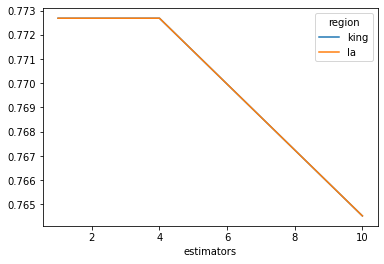

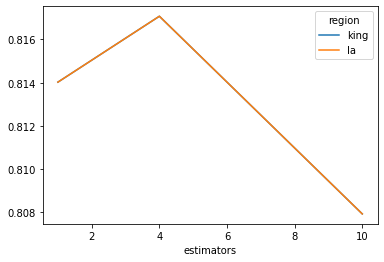

In [37]:
import matplotlib.pyplot as plt
metrics_df.pivot(index='estimators', columns='region', values='train_accuracy').plot(kind="line")
metrics_df.pivot(index='estimators', columns='region', values='test_accuracy').plot(kind="line")

### I can inspect data of the first run: feature_transformer

In [ ]:
run_pathspec = runs[0].pathspec
run_pathspec

In [25]:
Step(f"{run_pathspec}/score").task.data

<MetaflowData: train_accuracy_threshold, train_accuracy, n_estimators, feature_transformer, date_key, data_path, test_accuracy_threshold, date_key_path, test_accuracy, max_depth, train_partitions, feature_df, name, random_state, input_partition, random_forest, is_valid>

In [26]:
Step(f"{run_pathspec}/score").task.data.feature_transformer

ColumnTransformer(transformers=[('categorical_pipe',
                                 Pipeline(steps=[('missing_imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['pclass', 'sex', 'embarked', 'random_cat']),
                                ('numerical_pipe',
                                 Pipeline(steps=[('mean_imputer',
                                                  SimpleImputer())]),
                                 ['age', 'sibsp', 'parch', 'fare',
                                  'random_num']),
                                ('identity_pipe',
                                 Pipeline(steps=[('identity_func',
                                                  FunctionTransformer(accept_sparse=True,
                                                                      check_inverse=False))]),
                                 ['survived'])])

In [27]:
type(Step(f"{run_pathspec}/score").task.data.feature_transformer)

sklearn.compose._column_transformer.ColumnTransformer

## I can load the trained Random Forest 
* The whole model is now in this notebook
* Inspect it
* Predict with it

In [28]:
random_forest = Step(f"{run_pathspec}/score").task.data.random_forest
random_forest

RandomForestClassifier(bootstrap=False, max_depth=2, n_estimators=10,
                       random_state=42)

In [29]:
random_forest.estimator_params

('criterion',
 'max_depth',
 'min_samples_split',
 'min_samples_leaf',
 'min_weight_fraction_leaf',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'random_state',
 'ccp_alpha')

In [30]:
feature_df: pd.DataFrame = Step(f"{run_pathspec}/score").task.data.feature_df
feature_df

,pclass_1.0,pclass_2.0,pclass_3.0,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,random_cat_0,random_cat_1,random_cat_2,age,sibsp,parch,fare,random_num,survived
0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,29.963448,0.0,0.0,7.7333,-0.436386,1.0
1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,29.963448,0.0,0.0,7.7500,2.006093,1.0
2,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,38.000000,0.0,0.0,7.2292,0.521122,1.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,22.000000,0.0,0.0,7.8958,-2.135674,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,16.000000,0.0,0.0,9.5000,1.607346,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,29.963448,0.0,0.0,8.0500,0.766080,1.0
977,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,19.000000,0.0,0.0,8.0500,2.601683,1.0
978,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,34.000000,0.0,0.0,13.0000,0.346488,0.0
979,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,22.000000,0.0,0.0,8.0500,0.949554,0.0


In [32]:
feature_df.drop(columns="survived")

,pclass_1.0,pclass_2.0,pclass_3.0,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,random_cat_0,random_cat_1,random_cat_2,age,sibsp,parch,fare,random_num
0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,29.963448,0.0,0.0,7.7333,-0.436386
1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,29.963448,0.0,0.0,7.7500,2.006093
2,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,38.000000,0.0,0.0,7.2292,0.521122
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,22.000000,0.0,0.0,7.8958,-2.135674
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,16.000000,0.0,0.0,9.5000,1.607346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,29.963448,0.0,0.0,8.0500,0.766080
977,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,19.000000,0.0,0.0,8.0500,2.601683
978,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,34.000000,0.0,0.0,13.0000,0.346488
979,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,22.000000,0.0,0.0,8.0500,0.949554


In [33]:
predictions = random_forest.predict(feature_df.drop(columns="survived"))
predictions

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 1.

In [42]:
import tensorflow as tf
import tensorflow_data_validation as tfdv

feature_stats = tfdv.generate_statistics_from_dataframe(feature_df)
tfdv.visualize_statistics(feature_stats)

In [46]:
tfdv.visualize_statistics(tfdv.generate_statistics_from_dataframe(pd.DataFrame(feature_df["survived"])))

### Feature Importance Plot

<BarContainer object of 16 artists>

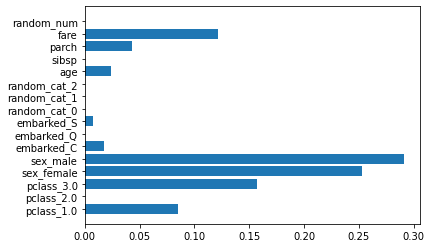

In [22]:
from matplotlib import pyplot as plt

plt.barh(feature_df.drop("survived", axis=1).columns, rf.feature_importances_)

## Organizing Flows and Experiments
- AIP by `tags` Flows by *user* and *KF Namespace* by default.
- You can query by `tag`

In [37]:
# lets see all the Flows that have run in this environment
from metaflow import Metaflow, namespace

list(Metaflow())

[Flow('ExampleFlow'),
 Flow('ForeachFlow'),
 Flow('DivisionFlow'),
 Flow('HashFileFlow'),
 Flow('RetryFlow'),
 Flow('FailureFlow'),
 Flow('CatchFlow'),
 Flow('S3DemoFlow')]

In [38]:
# lets see all the Flows that have run in this environment
from metaflow import Metaflow
namespace("user:yunw")
list(Metaflow())

[Flow('DivisionFlow')]

In [39]:
namespace(None)
list(Metaflow())

[Flow('NestedForeachTestFlow'),
 Flow('HelloPyTorch'),
 Flow('ExampleFlow'),
 Flow('NestedForeachWithBranching'),
 Flow('KfpGraphComponentFlow'),
 Flow('HelloPipeler'),
 Flow('KfpLoadComponent'),
 Flow('HelloFlow'),
 Flow('BranchFlow'),
 Flow('ForeachFlow'),
 Flow('SimpleArtifactFlow'),
 Flow('MyFlow'),
 Flow('ListingDemandFlow'),
 Flow('HelloZOML'),
 Flow('DivisionFlow'),
 Flow('MyBranchFlow'),
 Flow('MyBranchFlow1'),
 Flow('ExampleFlowTwo'),
 Flow('SuicidalFlow'),
 Flow('MyBranchFlow2'),
 Flow('TimeoutFlow'),
 Flow('HashFileFlow'),
 Flow('HelloFlow2'),
 Flow('ResourcesFlow'),
 Flow('RetryFlow'),
 Flow('FailureFlow'),
 Flow('SparkFlow'),
 Flow('CatchFlow'),
 Flow('S3DemoFlow'),
 Flow('KfpFlow')]

# Productionizing: Failure Handling

## @retry
* Pod failures are expected in distributed systems.
* `--with retry` or `@retry` guarentee N retry attempts.
* You can access the `current.retry_count`

In [22]:
%%writefile notify_demo/division_flow.py

from metaflow import FlowSpec, step, Parameter, current


class DivisionFlow(FlowSpec):
    numerator = Parameter("numerator", default=2)
    denominator = Parameter("denominator", default=4)
    
    @step
    def start(self):
        """
        This is the 'start' step. All flows must have a step named 'start' that
        is the first step in the flow.
        """
        print("DivisionFlow is starting.")
        if current.retry_count > 1:
            self.result = "NaN"
        else:
            print(f"Attempt {current.retry_count}!")
            self.result = float(self.numerator) / float(self.denominator)
            print("successful division!")
        self.next(self.end)

    @step
    def end(self):
        """
        This is the 'end' step. All flows must have an 'end' step, which is the
        last step in the flow.
        """
        print(f"Divison of {self.numerator} / {self.denominator} = {self.result}")
        print("HelloFlow is all done.")


if __name__ == '__main__':
    DivisionFlow()


Overwriting notify_demo/division_flow.py


In [40]:
!python notify_demo/division_flow.py run --denominator 0 

Metaflow 2.2.5 executing DivisionFlow for user:talebz
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2021-04-30 20:50:14.289 Workflow starting (run-id 309):
2021-04-30 20:50:14.418 [309/start/1530 (pid 1753)] Task is starting.
2021-04-30 20:50:16.987 [309/start/1530 (pid 1753)] <flow DivisionFlow step start> failed:
2021-04-30 20:50:16.988 [309/start/1530 (pid 1753)]     Internal error
2021-04-30 20:50:16.988 [309/start/1530 (pid 1753)] Traceback (most recent call last):
2021-04-30 20:50:16.988 [309/start/1530 (pid 1753)]   File "/opt/zillow/.venv/lib/python3.6/site-packages/metaflow/cli.py", line 927, in main
2021-04-30 20:50:16.988 [309/start/1530 (pid 1753)]     start(auto_envvar_prefix='METAFLOW', obj=state)
2021-04-30 20:50:16.988 [309/start/1530 (pid 1753)]   File "/opt/zillow/.venv/lib/python3.6/site-packages/click/core.py", line 829, in __call__
2021-04-30 20:50:16.988 [309/start/1530 (pid 1753)] DivisionFlow is starting.
2021-04-30 20:

In [41]:
!python notify_demo/division_flow.py run --denominator 0 --with retry 

Metaflow 2.2.5 executing DivisionFlow for user:talebz
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2021-04-30 20:50:33.981 Workflow starting (run-id 310):
2021-04-30 20:50:34.093 [310/start/1532 (pid 1795)] Task is starting.
2021-04-30 20:50:36.426 [310/start/1532 (pid 1795)] <flow DivisionFlow step start> failed:
2021-04-30 20:50:36.427 [310/start/1532 (pid 1795)]     Internal error
2021-04-30 20:50:36.427 [310/start/1532 (pid 1795)] Traceback (most recent call last):
2021-04-30 20:50:36.427 [310/start/1532 (pid 1795)]   File "/opt/zillow/.venv/lib/python3.6/site-packages/metaflow/cli.py", line 927, in main
2021-04-30 20:50:36.427 [310/start/1532 (pid 1795)] DivisionFlow is starting.
2021-04-30 20:50:36.427 [310/start/1532 (pid 1795)]     start(auto_envvar_prefix='METAFLOW', obj=state)
2021-04-30 20:50:36.427 [310/start/1532 (pid 1795)]   File "/opt/zillow/.venv/lib/python3.6/site-packages/click/core.py", line 829, in __call__
2021-04-30 20:

In [25]:
!python notify_demo/division_flow.py --with retry kfp run --denominator 0 

Metaflow 2.2.5 executing DivisionFlow for user:talebz
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
Uploaded package to: s3://serve-datalake-zillowgroup/zillow/workflow_sdk/metaflow_28d/dev/aip-example/DivisionFlow/data/a8/a881a9960415931986f223f003ba49e4719b6cb3
Deploying DivisionFlow to Kubeflow Pipelines...

Run created successfully!

Metaflow run_id=kfp-07d3e362-8081-4b7c-b430-497d3f748d7c 

Run link: https://kubeflow.corp.stage-k8s.zg-aip.net/_/pipeline/#/runs/details/07d3e362-8081-4b7c-b430-497d3f748d7c

Argo workflow: argo -n aip-example-dev watch divisionflow-h9l4z



## demo `@retry(times, minutes_between_retries)`

```python
class DivisionFlow(FlowSpec):
    
    @retry(times=1, minutes_between_retries=5)
    @step
    def start(self):
        ....
```

## `@catch` user errors
* You may expect a step to fail, and want to catch and handle the exception in the next step
* With `@catch` the step code becomes the `try` and `@catch` handles the exception

In [52]:
# %load /home/talebz/public-shared/taleb/demo_flows/catch_flow.py
import os
import signal
import time

from metaflow import FlowSpec, step, retry, catch, timeout, current
from metaflow.exception import MetaflowExceptionWrapper


class CatchFlow(FlowSpec):
    @catch(var="start_failed")
    @step
    def start(self):
        self.x = 1 / 0
        self.next(self.end)

    @step
    def end(self):
        print("We caught the start 1/0 exception")
        print(self.start_failed)
        print("All done.")


if __name__ == "__main__":
    CatchFlow()


In [27]:
!python demo_flows/catch_flow.py kfp run 

Metaflow 2.2.5 executing CatchFlow for user:talebz
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
Uploaded package to: s3://serve-datalake-zillowgroup/zillow/workflow_sdk/metaflow_28d/dev/aip-example/CatchFlow/data/34/3408b387787fa608730123547110425726008b50
Deploying CatchFlow to Kubeflow Pipelines...

Run created successfully!

Metaflow run_id=kfp-d47953d9-d431-4960-b6d4-32469855a58c 

Run link: https://kubeflow.corp.stage-k8s.zg-aip.net/_/pipeline/#/runs/details/d47953d9-d431-4960-b6d4-32469855a58c

Argo workflow: argo -n aip-example-dev watch catchflow-s9224



# AIP Namespace Dashboard
* Allows you to monitor your namespace usage per quota.
* Can drill down to the pod.
* [link](https://ai-platform.datadoghq.com/dashboard/zbk-9vj-zgm/ai-platform-namespace-dashboard?from_ts=1619463060000&live=false&to_ts=1619722260000&tpl_var_kube_namespace=rent-zestimate-prod)

# Documentation
* [link](http://analytics.pages.zgtools.net/artificial-intelligence/ai-platform/aip-docs/kubeflow/onboarding_to_aip.html)

----
# Recap

### Value proposition
Throughout this demo, we were able to discuss modeling (steps, states, variables, post-hoc analysis, etc), and did not have to think about the *how*.

How to:
* Copy (Code and Data) to a GPU instance.
* Share state between containers.
* Versioning: it is handled for you.
* Provision and use a cluster of GPUs: added `@pytorch` and `@resources(gpu=1)` decorator
* Organizing your flows and experiments
* Post-hoc analysis


**We remained at the higher level abstraction**:

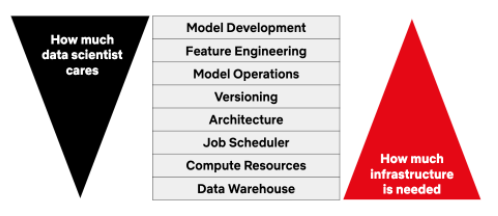



---
# Workflow SDK Developers
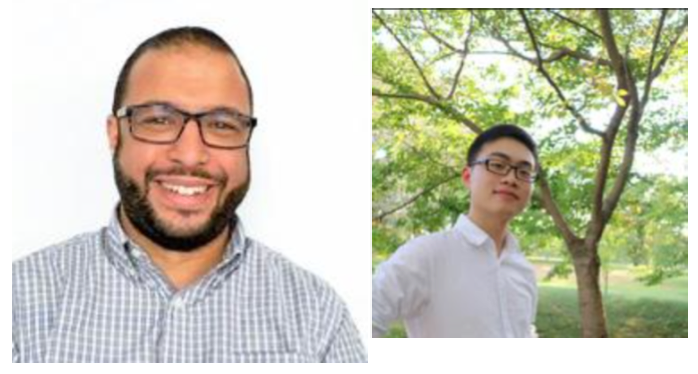

# Team!

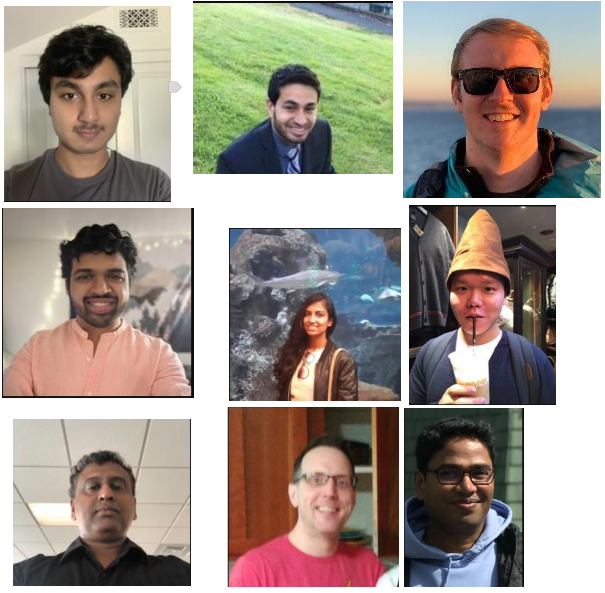

----
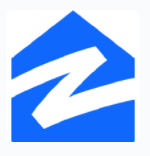 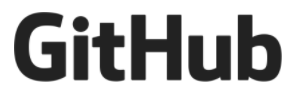  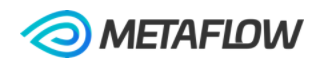


# https://github.com/zillow/metaflow  